In [2]:
# 1) load packages env py_dl
#racheli
import os
from keras.optimizers import RMSprop
import numpy as np
import pandas as pd 
import random
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D, regularization
from keras.layers import Embedding, Reshape, Activation
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import model_to_dot 
from keras.preprocessing.sequence import skipgrams
from keras.preprocessing import sequence
from keras.layers import SimpleRNN
from keras import initializers
import matplotlib.pyplot as plt
from IPython.display import SVG
%matplotlib inline
os.environ['OMP_NUM_THREADS'] = '50'

2023-07-31 11:26:34.531581: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# 2) constants and hyperparameters
L_RBNS = 20 # length of each sequence in RBNS data
O = int(1e7) # for initializing big arrays, helps reduce runtime
LIMIT_FILE_N_SEQ_READ = int(1e6) # limit the amount of seq we read from file, helps reduce runtime
ONE_HOT_DICT = {b'A': np.array([0,0,0,1], dtype=np.float16),
                b'C': np.array([0.,0.,1,0], dtype=np.float16),
                b'G': np.array([0,1,0,0], dtype=np.float16),
                b'T': np.array([1,0,0,0], dtype=np.float16),
                b'U': np.array([1,0,0,0], dtype=np.float16),
                b'N': np.array([0.25,0.25,0.25,0.25])
                }

ONE_HOT_DICT2 = {'A':[0,0,0,1],
                'C': [0,0,1,0],
                'G':[0,1,0,0],
                'T': [1,0,0,0],
                'U': [1,0,0,0],
                'N': [0.25,0.25,0.25,0.25]
                }

L_RBNS = 20 # length of each sequence in RBNS data
FILES_40 = ["RBP9" , "RBP11", "RBP15", "RBP31"] # files  with sequences len 40 and not 20

In [4]:
# 3) read files 
# list of files in RBNS_training
directory = '/data01/private/resources/RACHELI_EDEN_SHARED/DL_PROJ/RBNS_training'
RBNS_training_files = []
for filename in os.listdir(directory): # Iterate over all files in the directory
    if os.path.isfile(os.path.join(directory, filename)):
        RBNS_training_files.append(filename)
print(RBNS_training_files)

# filter out protein 1 files only
PROTEIN = "RBP1" ### TODO change 
filtered_list = [value for value in RBNS_training_files if value.startswith(str(PROTEIN)+'_')]

prefixes = [item.split('_', 1)[0] for item in filtered_list]
suffixes = [item.split('_', 1)[1] for item in filtered_list]

# find the middle affinity files
modified_list = [value.replace('RBP1_', '').replace('nM.seq', '') for value in filtered_list]
if 'RBP1_input.seq' in filtered_list: # get rid of input
    modified_list.remove('input.seq')
modified_list = sorted(modified_list, key=int)

# modified_list = [PROTEIN + "_" + value + "nM.seq" for value in modified_list[1:3]]  # the first 2 files
modified_list = [PROTEIN + "_" + value + "nM.seq" for value in [modified_list[1], modified_list[-2]]]  # the first 2 files
modified_list.append(str(PROTEIN+'_input.seq')) # 0
modified_list

['RBP10_1300nM.seq', 'RBP10_20nM.seq', 'RBP10_320nM.seq', 'RBP10_5nM.seq', 'RBP10_80nM.seq', 'RBP10_input.seq', 'RBP11_1090nM.seq', 'RBP11_121nM.seq', 'RBP11_13nM.seq', 'RBP11_1nM.seq', 'RBP1_1300nM.seq', 'RBP11_3280nM.seq', 'RBP11_365nM.seq', 'RBP11_40nM.seq', 'RBP11_4nM.seq', 'RBP11_9800nM.seq', 'RBP11_input.seq', 'RBP1_20nM.seq', 'RBP12_1300nM.seq', 'RBP12_20nM.seq', 'RBP12_320nM.seq', 'RBP12_5nM.seq', 'RBP12_80nM.seq', 'RBP12_input.seq', 'RBP13_1300nM.seq', 'RBP1_320nM.seq', 'RBP13_20nM.seq', 'RBP13_320nM.seq', 'RBP13_5nM.seq', 'RBP13_80nM.seq', 'RBP13_input.seq', 'RBP14_1300nM.seq', 'RBP14_20nM.seq', 'RBP14_320nM.seq', 'RBP14_5nM.seq', 'RBP14_80nM.seq', 'RBP14_input.seq', 'RBP15_1300nM.seq', 'RBP15_20nM.seq', 'RBP15_320nM.seq', 'RBP15_5nM.seq', 'RBP15_80nM.seq', 'RBP15_input.seq', 'RBP1_5nM.seq', 'RBP16_1300nM.seq', 'RBP16_20nM.seq', 'RBP16_320nM.seq', 'RBP16_5nM.seq', 'RBP16_80nM.seq', 'RBP16_input.seq', 'RBP1_80nM.seq', 'RBP1_input.seq', 'RBP2_1300nM.seq', 'RBP2_20nM.seq', 'RBP2

['RBP1_20nM.seq', 'RBP1_320nM.seq', 'RBP1_input.seq']

In [5]:
# 4) BINARY classification - 
# initalize np.arrays
master_list = np.empty((O), dtype=f'|S{L_RBNS}') # sequences
class_lables = np.zeros((O, len(modified_list))) # array of probolities per class
n = 0

## running on protein 1 files only ############################################################
for file_index, file in enumerate(modified_list):
    #print(file_index)
    file_path = '/data01/private/resources/RACHELI_EDEN_SHARED/DL_PROJ/RBNS_training/' + file
    with open(file_path, 'r') as file:
        lines = file.readlines()
        # choose sequences from file randomly - limited to LIMIT_FILE_N_SEQ_READ
        rng = np.random.default_rng(seed=123)
        rand_indices = rng.choice(len(lines), size=LIMIT_FILE_N_SEQ_READ, replace=False)

        # cut seq to 20 length randomly if len is longer find a random starting index and take 20 from there
        if file in FILES_40: # file len 40
            # choose random index to start from and select 20 chars - save shortend seq into master_list
            start_index = random.randint(0, 20)
            for index in rand_indices:
                seq = lines[index].split('\t')[0] # take only the sequence
                master_list[n] = seq[start_index:start_index+20] # shortened seq
                if file == str(PROTEIN+'_input.seq'):
                    class_lables[n, file_index] = 0
                else:
                    class_lables[n, file_index] = 1 # lables - 1 if in file otherwise stays 0
                n += 1
        elif file == str(PROTEIN+'_input.seq'):
              for index in rand_indices:
                    seq = lines[index].split('\t')[0] # take only the sequence
                    master_list[n] = seq # seq
                    class_lables[n, file_index] = 0 # lables - 1 if in file otherwise stays 0
                    n += 1
        else: # file len 20 + isnt input.seq
            for index in rand_indices:
                    seq = lines[index].split('\t')[0] # take only the sequence
                    master_list[n] = seq # seq
                    class_lables[n, file_index] = 1 # lables - 1 if in file otherwise stays 0
                    n += 1

# free memory initlized that wasnt used 
master_list = master_list[:n]
class_lables = class_lables[:n]
del lines

# binary vec
class_lables_binary = np.where(((class_lables[:, 0] == 1) | (class_lables[:, 1] == 1)) & (class_lables[:, 2] == 0), 1, 0)
class_lables_binary

# convert master_list seqences to one hot encoding
one_hot = np.zeros((len(master_list),  L_RBNS, 4), dtype=np.float16)
one_hot = np.array([ONE_HOT_DICT[bytes([nuc])] for seq in master_list for nuc in seq])
one_hot = one_hot.reshape(len(master_list), -1, 4)

In [7]:
# 5) back up: MULTICALSS = initalize np.arrays
# master_list = np.empty((O), dtype=f'|S{L_RBNS}') # sequences
# # class_lables = np.zeros((O, len(filtered_list)), dtype=np.bool_) # array of probolities per class
# class_lables = np.zeros((O, len(filtered_list))) # array of probolities per class
# n = 0

# ## running on protein 1 files only ############################################################
# for file_index, file in enumerate(filtered_list):
#     #print(file_index)
#     file_path = '/data01/private/resources/RACHELI_EDEN_SHARED/DL_PROJ/RBNS_training/' + file
#     with open(file_path, 'r') as file:
#         lines = file.readlines()
#         # choose sequences from file randomly - limited to LIMIT_FILE_N_SEQ_READ
#         rng = np.random.default_rng(seed=123)
#         rand_indices = rng.choice(len(lines), size=LIMIT_FILE_N_SEQ_READ, replace=False)

#         # cut seq to 20 length randomly if len is longer find a random starting index and take 20 from there
#         if file in FILES_40: # file len 40
#             # choose random index to start from and select 20 chars - save shortend seq into master_list
#             start_index = random.randint(0, 20)
#             for index in rand_indices:
#                 seq = lines[index].split('\t')[0] # take only the sequence
#                 master_list[n] = seq[start_index:start_index+20] # shortened seq
#                 class_lables[n, file_index] = 1 # lables - 1 if in file otherwise stays 0
#                 n += 1
#         else: # file len 20
#             for index in rand_indices:
#                     seq = lines[index].split('\t')[0] # take only the sequence
#                     master_list[n] = seq # seq
#                     class_lables[n, file_index] = 1 # lables - 1 if in file otherwise stays 0
#                     n += 1
# # free memory initlized that wasnt used 
# master_list = master_list[:n]
# class_lables = class_lables[:n]
# del lines
# # # convert master_list seqences to one hot encoding
# one_hot = np.zeros((len(master_list),  L_RBNS, 4), dtype=np.float16)
# one_hot = np.array([ONE_HOT_DICT[bytes([nuc])] for seq in master_list for nuc in seq])
# one_hot = one_hot.reshape(len(master_list), -1, 4)

# # for i, seq in enumerate(master_list): # each seq
# #     for j, nuc in enumerate(seq): # each nucleotide
# #         one_hot[i, j, :] = ONE_HOT_DICT[bytes([nuc])] # dim 6000000 seq * 20 * 4

In [6]:
# 6) split into training and validation sets -- 80% training, 20% validation
# TODO LATER: keep out 6~ proteins for validation of the end
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
one_hot_train_X, one_hot_valid_X, one_hot_train_Y, one_hot_valid_Y = train_test_split(one_hot, class_lables_binary, test_size=0.2, random_state=42)
# train_X, test_X, train_y, test_y = train_test_split(one_hot, class_labels, test_size=0.2, random_state=42)

# Print the shapes of the resulting sets
print(master_list.shape,class_lables.shape, one_hot.shape)
print(one_hot_train_X.shape, one_hot_train_Y.shape, one_hot_valid_X.shape, one_hot_valid_Y.shape)

(3000000,) (3000000, 3) (3000000, 20, 4)
(2400000, 20, 4) (2400000,) (600000, 20, 4) (600000,)


In [46]:
# 8) step 2) NN per protien - input each seq (len 20) in master_list into NN 
    # output = vec of probabilities (one per each concentration)
    # compare output to bool numpy array (true lable)
    # backpropogation to model to minimize loss?

model_param_dict = {"kernel_size":3, "pool_size":2, "layers": [32], "final_activation_function":"sigmoid"}
output_size=1 # number of classes

# # first try - simple NN
# model_1=Sequential()
# model_1.add(Dense(11, activation="relu",input_shape=one_hot_train_X.shape[1:]))
# model_1.add(Flatten())
# model_1.add(Dense(output_size, activation=model_param_dict['final_activation_function'])) # softmax

# second try - CNN
model_2 = Sequential()
model_2.add(Conv1D(filters=32, kernel_size=model_param_dict["kernel_size"], strides=1,\
                 kernel_initializer=initializers.RandomNormal(stddev=0.01), \
                 activation='relu',\
                 input_shape=one_hot_train_X.shape[1:], use_bias=True, bias_initializer='RandomNormal'))

model_2.add(MaxPooling1D(pool_size=model_param_dict["pool_size"], strides=None, padding='valid', data_format='channels_last'))
model_2.add(Flatten())
# per layer
for layer_size in model_param_dict['layers']:
            print(f'the layer size is: {layer_size}')
            model_2.add(Dense(layer_size, activation='relu'))
model_2.add(Dense(output_size, activation=model_param_dict['final_activation_function'])) # sigmoid

from keras.optimizers import Adam, SGD, RMSprop
# Hyperparameters
EPHOCHS = 1
model = model_2
model.compile(optimizer=SGD(lr = .003), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

# Generate dummy data for training
X_train_norm = one_hot_train_X
y_train = one_hot_train_Y

# Compile the model with Optimizer, Loss Function and Metrics
run_hist_1 = model.fit(X_train_norm, y_train, batch_size=128, epochs=EPHOCHS, validation_data=(one_hot_valid_X, one_hot_valid_Y), shuffle=True)
model.save('/data01/private/resources/RACHELI_EDEN_SHARED/DL_PROJ/model_sig_80_320.h5') # save the model


the layer size is: 32


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 18, 32)            416       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 9, 32)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 288)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                9248      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 9,697
Trainable params: 9,697
Non-trainable params: 0
____________________________________________________

/home/ls/meidane/miniconda3/envs/py_dl/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


18750/18750 [==============================] - 617s 33ms/step - loss: 0.6366 - accuracy: 0.6667 - val_loss: 0.6361 - val_accuracy: 0.6666


In [7]:
# load the model
model = keras.models.load_model("/data01/private/resources/RACHELI_EDEN_SHARED/DL_PROJ/model_sig_80_320.h5")

2023-07-31 11:27:39.382810: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 11:27:39.398012: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 3. Tune using inter_op_parallelism_threads for best performance.


In [ ]:
# TODO - hyperparameter tuning
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()
# hyperparameters to play with:
# 1) number of layers -- 1, 2, 3
# 2) number of neurons per layer -- 32, 64, 128
# 3) activation function -- "relu", "sigmoid", "tanh"
# 4) optimizer -- "adam", "sgd", "rmsprop"
# 5) learning rate -- 0.001, 0.01, 0.1
# 6) batch size -- 8, 16, 32
# 7) number of epochs -- 2, 4, 8
# 8) kernel size -- 3, 5, 7
# 9) pool size -- 2, 3, 4

In [8]:
# cut seg from RNAcomplete file into all shifts of len 20
# read txt file
file_path = '/data01/private/resources/RACHELI_EDEN_SHARED/DL_PROJ/RNAcompete_sequences.txt'
with open(file_path, 'r') as file:
    # convert seqences to one hot encoding
    RNAcompete_master_list_one_hot = [[ONE_HOT_DICT2[nuc] for nuc in ((41 - len(seq.rstrip('\n'))) * 'N' + seq.rstrip('\n'))] for seq in file if len(seq) > 5]
# cut seg from RNAcomplete file into all shifts of len 20 -- create k-mers of all possible shifts 
shifts_RNAcompete_master_list = [[seq[i:i+20] for i in range(0, len(seq) - 20 + 1, 5)] for seq in RNAcompete_master_list_one_hot] # step +5
# shifts_RNAcompete_master_list = [[seq[i:i+20] for i in range(len(seq) - 20 + 1)] for seq in RNAcompete_master_list_one_hot]    # step +1
# shifts_RNAcompete_master_list = [seq[2] for seq in shifts_RNAcompete_master_list]                                              # take only the middle shift

shifts_RNAcompete_master_list = np.array(shifts_RNAcompete_master_list)

# parallelize the prediction + output ##################################################################################################################
import concurrent.futures
import numpy as np
# Assuming you have a Keras model named 'model' and a list 'shifts_RNAcompete_master_list'
def get_max_prediction(shifts):
    return max(model.predict(shifts)) # !!!!!!
num_cores = 90 #multiprocessing.cpu_count()
print(f"Number of CPU cores: {num_cores}")

# Using ThreadPoolExecutor to parallelize the predictions
with concurrent.futures.ProcessPoolExecutor(max_workers=num_cores) as executor:
    predictions = list(executor.map(get_max_prediction, shifts_RNAcompete_master_list))
# predictions = np.array(predictions)  # Convert predictions list to a NumPy array if needed

# # write pred into file
# protein="RBP1"
# with open(f'/data01/private/resources/RACHELI_EDEN_SHARED/DL_PROJ/predicition1_{protein}.txt', "w") as file:
#     for pred in predictions:
#         file.write(f'{pred}\n')

Number of CPU cores: 90


In [61]:
len(shifts_RNAcompete_master_list[0][1])

4

In [14]:
# read pred + check correlation
import scipy.stats as stats
with open('/data01/private/resources/RACHELI_EDEN_SHARED/DL_PROJ/RNCMPT_training/RBP1.txt','r') as file:
    y_target=[float(line.strip()) for line in file] ### y
       
with open('/data01/private/resources/RACHELI_EDEN_SHARED/DL_PROJ/predicition1_RBP1_all.txt','r') as file:
    y_hat=[float(line.strip('[]\n')) for line in file] ### x

correlation_coefficient, p_value = stats.pearsonr(y_target, y_hat)
print("Pearson correlation coefficient:", correlation_coefficient, "p-value:", p_value)

Pearson correlation coefficient: 0.035591214882169625 p-value: 1.685620275812646e-68


Coefficients: [14.78409067]
Intercept: -9.29897290614571


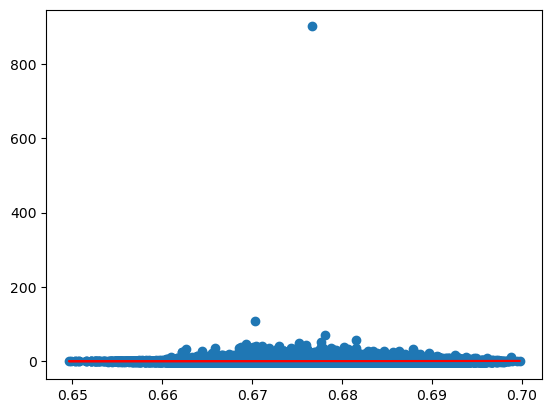

In [58]:
# LinearRegression - between y_hat and y_target
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
X = np.array(y_hat).reshape(-1, 1)  # Independent variable (features)
y = np.array(y_target)  # Dependent variable (target)

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Print the coefficients (slope and intercept)
print("Coefficients:", model.coef_)     # Slope
print("Intercept:", model.intercept_)   # Intercept
print("Maximum:", max(y_pred))
print("Minimum:", min(y_pred))

# Visualize the linear regression line
plt.scatter(X, y) 
plt.plot(X, y_pred, color='red', label='Linear Regression') ## model
plt.show()

In [45]:
# # create prediction per seq - take max pred from all shifts
# predictions = [max(model.predict(shifts)) for shifts in shifts_RNAcompete_master_list]
# predictions

1/1 [==============================] - 0s 57ms/step


In [38]:
# # test -- one seq from input file -- should calssify as 0 - check!

# file_path = '/data01/private/resources/RACHELI_EDEN_SHARED/DL_PROJ/RBNS_training/RBP1_input.txt'
# with open(file_path, 'r') as file:
#     first_line = file.readline()
#     second_line = file.readline()

# # Extract the first element from both lines
# seq1 = first_line.split('\t')[0]
# seq2 = second_line.split('\t')[0]
# # print(seq1)

# one_hot_test_1 = np.array([ONE_HOT_DICT2[(nuc)] for nuc in seq1])
# one_hot_test_2 = np.array([ONE_HOT_DICT2[(nuc)] for nuc in seq2])
# # print(one_hot_test_1.shape)
# # print(one_hot_test_1)
# one_hot_test = np.array([one_hot_test_1, one_hot_test_2])
# # one_hot_test.shape

# # print(one_hot_test)
# # print(one_hot_test.shape)
# # model.predict(one_hot_test)

# # create prediction per seq - take max pred 1 seq
# predictions = [model.predict(one_hot_test)]
# predictions

1/1 [==============================] - 0s 115ms/step


[array([[0.6634457 ],
        [0.64907414]], dtype=float32)]

In [37]:
# # test --  one seq from input file -- should calssify as 1 - check!

# file_path = '/data01/private/resources/RACHELI_EDEN_SHARED/DL_PROJ/RBNS_training/RBP1_80nM.seq'
# with open(file_path, 'r') as file:
#     first_line = file.readline()
#     second_line = file.readline()

# # Extract the first element from both lines
# seq1 = first_line.split('\t')[0]
# seq2 = second_line.split('\t')[0]
# # print(seq1)

# one_hot_test_1 = np.array([ONE_HOT_DICT2[(nuc)] for nuc in seq1])
# one_hot_test_2 = np.array([ONE_HOT_DICT2[(nuc)] for nuc in seq2])
# print(one_hot_test_1.shape)
# # print(one_hot_test_1)
# one_hot_test = np.array([one_hot_test_1, one_hot_test_2])
# # print(one_hot_test.shape)
# # print(one_hot_test)

# # print(one_hot_test)
# # print(one_hot_test.shape)
# # model.predict(one_hot_test)

# # # create prediction per seq - take max pred 1 seq
# predictions = [model.predict(one_hot_test)]
# predictions

(20, 4)
1/1 [==============================] - 0s 78ms/step


[array([[0.67058665],
        [0.67228156]], dtype=float32)]

In [41]:
# # # cut seg from RNAcomplete file into all shifts of len 20
# # RNAcompete_master_list_one_hot = np.empty((O), dtype=f'|S{L_RBNS*2}') # sequences

# # # read txt file
# # file_path = '/data01/private/resources/RACHELI_EDEN_SHARED/DL_PROJ/RNAcompete_sequences.txt'
# # with open(file_path, 'r') as file:
# #     # convert seqences to one hot encoding
# #     RNAcompete_master_list_one_hot = [[ONE_HOT_DICT2[nuc] for nuc in seq.rstrip('\n')] for seq in file]

# # cut seg from RNAcomplete file into all shifts of len 20
# shifts_RNAcompete_master_list = np.empty((O), dtype=object) # sequences

# for n, seq_onehot in enumerate(RNAcompete_master_list_one_hot): # seq
#     line_length = len(seq_onehot)
#     if line_length > 20: # create k-mers of all possible shifts 
#         shifts = np.empty((line_length - 20), dtype=object)
#         j=0
#         if j <= 6:
#             for i in range(line_length - 20): # shift
#                 shifts[i] = np.array(seq_onehot[j:j+20])
#                 j+=3
#         shifts_RNAcompete_master_list[n] = shifts
#     else:
#         shifts_RNAcompete_master_list[n] = seq_onehot
                
# # shifts_RNAcompete_master_list[:n]

In [50]:
type(y_target)

list

In [26]:
# convert list to 2d df
# pd.DataFrame(y_hat)
np.array(y_hat).reshape(-1, 1)

(241357, 1)

In [24]:
# logistic regresstion - maximizenp
# input: features output:
import statsmodels.api as sm


y_pred = sm.add_constant(df)

# Create a logistic regression model
logit_model = sm.Logit(y_target, y_pred)
logit_result = logit_model.fit()
print(logit_result.summary())

ValueError: endog must be in the unit interval.

In [32]:
type(y_target)

list

In [ ]:
# TRY THIS AS WELL
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()

# hyperparameters to play with: 
# 1) number of layers
# 2) number of neurons per layer
# 3) activation function
# 4) optimizer
# 5) learning rate
# 6) batch size
# 7) number of epochs

cut

In [ ]:
# # cut seg from RNAcomplete file into all shifts of len 20
# shifts_RNAcompete_master_list = np.empty((O), dtype=object) # sequences


# with open(file_path, 'r') as file:
#         for n, line in enumerate(file):
#             line = line.rstrip('\n')  # Remove newline character from the end
#             line_length = len(line)
#             if line_length > 20: # create k-mers of all possible shifts 
#                 shifts = np.empty((line_length - 20 + 1), dtype=f'|S{L_RBNS}')
#                 for i in range(line_length - 20 + 1):
#                     shifts[i] = line[i:i+20]
#                     #shifts_RNAcompete_master_list[n] = line[i:i+20]
#                     # n += 1
#                 shifts_RNAcompete_master_list[n] = shifts
#             else:
#                 shifts_RNAcompete_master_list[n] = line
                
# shifts_RNAcompete_master_list[:n]

In [33]:
# input to NN shifts_RNAcompete_master_list sequences



10000000

In [ ]:
# 3) take all sequences from file RNAcompete_2009_dataset.txt and input into NNcomplete_sequnces.txt (seq len 30-40)
# create all possible k-mers with shift 1 (len 20) 
# input into NN
# choose max and min (features) probability for each full sequence - find best k-mer


In [ ]:
# 4) model feature to find RNCMPT_train on all proteins

#

In [ ]:
# logistic regresstion -maximize 
# input: features
# output: 